In [1]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

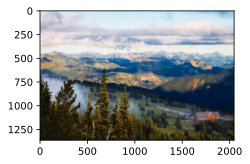

In [2]:
d2l.set_figsize()
content_img = d2l.Image.open('./img/rainier.jpg')
d2l.plt.imshow(content_img)

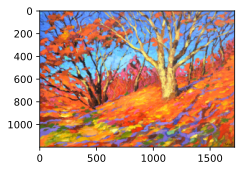

In [3]:
style_img = d2l.Image.open('./img/autumn-oak.jpg')
d2l.plt.imshow(style_img);

预处理和后处理

In [4]:
'''
定义RGB均值和标准差

这两行代码定义了RGB通道的均值和标准差，用于图像的归一化处理。
这里的数值是预训练的神经网络（如VGG网络）常用的值。
'''
rgb_mean = torch.tensor([0.485, 0.456, 0.406])
rgb_std = torch.tensor([0.229, 0.224, 0.225])

In [5]:
'''
图像预处理函数
1. 调整图像大小到`image_shape`。
2. 将图像转换为Tensor格式。
3. 使用之前定义的`rgb_mean`和`rgb_std`进行归一化处理。
4. `unsqueeze(0)`增加一个维度，使图像符合神经网络输入的形状（批量大小为1）。

'''
def preprocess(img, image_shape):
    transforms = torchvision.transforms.Compose(
        [
            torchvision.transforms.Resize(image_shape),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(mean=rgb_mean, std=rgb_std)
        ]
    )
    return transforms(img).unsqueeze(0)

In [6]:
'''
图像后处理函数
`postprocess`函数对神经网络输出的图像进行后处理，以便于可视化：
1. 取出批量中的第一个图像。
2. 将图像的通道顺序从（C, H, W）变为（H, W, C），
再反归一化（乘以标准差并加上均值），
同时使用`torch.clamp`将像素值限制在0到1之间。
3. 将图像转换为PIL格式，便于显示或保存。

'''
def postprocess(img):
    img = img[0].to(rgb_std.device)
    img = torch.clamp(img.permute(1, 2, 0) * rgb_std + rgb_mean, 0, 1)
    return torchvision.transforms.ToPILImage()(img.permute(2, 0, 1))

In [7]:
# 加载预训练的VGG19模型，该模型在ImageNet数据集上进行过训练。
pretrained_net = torchvision.models.vgg19(pretrained=True)

C:\Users\13498\anaconda3\envs\mul\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\13498\anaconda3\envs\mul\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
'''
- `style_layers` 是用于提取风格特征的层的索引列表。
- `content_layers` 是用于提取内容特征的层的索引列表。
'''
style_layers, content_layers = [0, 5, 10, 19, 28], [25]


In [24]:
'''
- 创建一个新的网络`net`，该网络包含VGG19模型中从第0层到最大层索引的所有层。
这些层将用于特征提取。

max(content_layers + style_layers): 28
range(max(content_layers + style_layers) + 1): range(0, 29)
'''
net = nn.Sequential(
    *[
        pretrained_net.features[i] for i in
        range(
            max(content_layers + style_layers) + 1
        )
    ]
)

In [26]:
'''
特征提取函数
`extract_features`函数用于从输入图像`X`中提取内容和风格特征：
- 初始化空列表`contents`和`styles`来存储特征。
- 遍历`net`中的每一层，将输入图像`X`通过每一层。
- 如果当前层索引在`style_layers`中，将其输出添加到`styles`中。
- 如果当前层索引在`content_layers`中，将其输出添加到`contents`中。
- 返回`contents`和`styles`。

len(net): 29
'''
def extract_features(X, content_layer, style_layers):
    contents = []
    styles = []
    for i in range(len(net)):
        X = net[i](X)
        if i in style_layers:
            styles.append(X)
        if i in content_layers:
            contents.append(X)
    return contents, styles


In [11]:
'''
获取内容特征函数
`get_contents`函数用于获取内容图像的特征：
- 将内容图像预处理并移动到指定设备`device`上。
- 使用`extract_features`函数提取内容特征。
- 返回预处理后的内容图像和内容特征。

'''
def get_contents(image_shape, device):
    content_X = preprocess(
        content_img, 
        image_shape
    ).to(device)
    contents_Y, _ = extract_features(
        content_X, content_layers, style_layers
    )
    return content_X, contents_Y

In [12]:
'''
获取风格特征函数

`get_styles`函数用于获取风格图像的特征：
- 将风格图像预处理并移动到指定设备`device`上。
- 使用`extract_features`函数提取风格特征。
- 返回预处理后的风格图像和风格特征。
'''
def get_styles(image_shape, device):
    style_X = preprocess(
        style_img,
        image_shape
    ).to(device)
    _, style_Y = extract_features(
        style_X, content_layers, style_layers
    )
    return style_X, style_Y

定义损失函数

内容损失

In [13]:
'''
内容损失函数
`content_loss`函数用于计算内容损失：
- `Y_hat`是生成图像的内容特征。
- `Y`是内容图像的内容特征。
- `Y.detach()`将`Y`从计算图中分离出来，使其成为一个固定值而不是一个变量。
- 计算`Y_hat`和`Y`之间的均方误差。

'''

def content_loss(Y_hat, Y):
    # 从动态计算梯度的树中分离目标
    # 这是一个规定的值，而不是一个变量
    return torch.square(Y_hat -Y.detach()).mean()

### 什么是 `detach`？
在 PyTorch 中，`detach()` 是一个张量（tensor）的方法，用于从计算图（computation graph）中分离张量。它会返回一个新的张量，这个新的张量与原张量具有相同的数据，但不再与计算图相关联。简而言之，使用 `detach()` 可以阻止梯度回传。

### 为什么要使用 `detach`？
在神经风格迁移中，我们需要计算内容损失和风格损失。为了计算这些损失，我们将原始图像的特征视为固定的目标值，而不是训练过程中的变量。这样可以避免在计算损失时意外地修改原始图像的特征。

### 在代码中的具体用法
```python
def content_loss(Y_hat, Y):
    # 我们从动态计算梯度的树中分离目标：
    # 这是一个规定的值，而不是一个变量。
    return torch.square(Y_hat - Y.detach()).mean()
```

这里的 `Y` 是原始内容图像的特征张量。我们希望在计算内容损失时，这些特征保持不变，不会被梯度更新。因此，我们使用 `Y.detach()` 将其从计算图中分离出来。

### 更详细的解释：
假设 `Y` 是通过某个网络层计算得到的特征，那么它实际上是通过多层神经网络的前向传播得到的，且这些操作都记录在计算图中。如果我们不使用 `detach()`，在计算损失 `torch.square(Y_hat - Y).mean()` 时，PyTorch 会继续记录这些操作，并在反向传播（backpropagation）时试图更新这些层的参数，这显然是不合理的，因为我们并不希望改变原始图像的特征。

通过使用 `Y.detach()`，我们明确告诉 PyTorch：`Y` 是一个常量，不是训练中的变量，不需要计算梯度。因此，计算图中与 `Y` 相关的所有操作都会被剪断，确保反向传播时 `Y` 不会对梯度产生影响。

### 举例说明：
设想以下简单情况：
```python
a = torch.tensor([2.0], requires_grad=True)
b = a * 2
c = b.detach()
d = b + 3

d.backward()
```

在这个例子中：
- `a` 是一个需要计算梯度的张量。
- `b = a * 2` 仍然是一个需要计算梯度的张量，因为它依赖于 `a`。
- `c = b.detach()` 则是一个与计算图分离的张量，`c` 是一个新的张量，它包含 `b` 的值，但不参与梯度计算。
- `d = b + 3` 会参与梯度计算，因为它依赖于 `b`。

当我们调用 `d.backward()` 时，`a` 的梯度会被更新，因为 `d` 依赖于 `b`，而 `b` 又依赖于 `a`。但是，`c` 不会被更新，因为它已经从计算图中分离出来。

### 在风格迁移中的应用
在神经风格迁移中，我们不希望原始内容图像和风格图像的特征在训练过程中被修改。我们希望这些特征保持不变，作为计算损失的参考。因此，使用 `detach()` 可以确保它们不会被误修改。

希望以上解释能帮助你更好地理解 `detach()` 的作用及其在神经风格迁移中的使用。如果还有其他问题，请随时问我！


风格损失

In [14]:
'''
Gram矩阵和风格损失函数
`gram`函数用于计算Gram矩阵：
- `num_channels`是特征图的通道数。
- `n`是特征图中每个通道的元素数量。
- 将特征图重新形状为`(num_channels, n)`。
- 计算Gram矩阵并归一化。
'''
def gram(X):
    num_channels, n = X.shape[1], X.numel() // X.shape[1]
    X = X.reshape((num_channels, n))
    return torch.matmul(X, X.T) / (num_channels * n)

`X.numel()` 返回张量 `X` 中的所有元素的数量，而 `X.shape[1]` 返回 `X` 的第二个维度的大小。我们来详细解释一下 `X.numel()` 和 `X.numel() // X.shape[1]` 的含义。

### `X.numel()`
`X.numel()` 是 PyTorch 中的一个方法，它返回张量 `X` 中的所有元素的总数量。比如说，如果 `X` 的形状是 `(2, 3, 4)`，那么 `X.numel()` 将返回 `2 * 3 * 4 = 24`。

### `X.shape`
`X.shape` 返回张量 `X` 的形状。对于一个形状为 `(num_channels, height, width)` 的特征图张量，`X.shape[1]` 将返回 `height`。

### 解释 `X.numel() // X.shape[1]`
假设 `X` 是一个形状为 `(num_channels, height, width)` 的特征图张量：
- `X.numel()` 返回 `X` 中所有元素的数量，即 `num_channels * height * width`。
- `X.shape[1]` 返回 `height`。

因此，`X.numel() // X.shape[1]` 计算的是每个通道的元素数量，即每个通道的宽度乘以高度的数量。具体计算如下：

```python
num_elements_per_channel = (num_channels * height * width) // height
                         = num_channels * width
                         = num_elements_per_channel_per_channel
```

### 具体应用
我们可以更详细地看看如何应用这一计算来实现 Gram 矩阵的计算。

假设 `X` 是一个特征图张量，其形状为 `(num_channels, height, width)`：

```python
def gram(X):
    num_channels, n = X.shape[1], X.numel() // X.shape[1]
    X = X.reshape((num_channels, n))
    return torch.matmul(X, X.T) / (num_channels * n)
```

### 具体步骤：
1. **计算通道数量和每个通道的元素数量**：
    - `num_channels` 是通道数量。
    - `n` 是每个通道的元素数量，等于 `X.numel() // X.shape[1]`。

2. **重塑张量**：
    - `X = X.reshape((num_channels, n))` 将张量 `X` 重塑为形状 `(num_channels, n)`，即每一行表示一个通道的所有元素。

3. **计算 Gram 矩阵**：
    - `torch.matmul(X, X.T)` 计算 `X` 和其转置的矩阵乘法，得到一个形状为 `(num_channels, num_channels)` 的矩阵。
    - `torch.matmul(X, X.T) / (num_channels * n)` 对结果进行归一化，得到 Gram 矩阵。

### 具体例子：
假设 `X` 的形状为 `(3, 4, 5)`：
- `X.numel()` 返回 `3 * 4 * 5 = 60`。
- `X.shape[1]` 返回 `4`，即 `height`。
- `X.numel() // X.shape[1]` 返回 `60 // 4 = 15`，即每个通道的元素数量。

将 `X` 重塑为 `(3, 15)`，然后计算 Gram 矩阵。

希望以上解释能帮助你理解 `X.numel()` 和 `X.numel() // X.shape[1]` 的含义及其在计算中的作用。如果有其他问题，请随时问我！


-----

`X.numel()` 返回张量 `X` 中的所有元素的数量，而 `X.shape[1]` 返回 `X` 的第二个维度的大小。我们来详细解释一下 `X.numel()` 和 `X.numel() // X.shape[1]` 的含义。

### `X.numel()`
`X.numel()` 是 PyTorch 中的一个方法，它返回张量 `X` 中的所有元素的总数量。比如说，如果 `X` 的形状是 `(2, 3, 4)`，那么 `X.numel()` 将返回 `2 * 3 * 4 = 24`。

### `X.shape`
`X.shape` 返回张量 `X` 的形状。对于一个形状为 `(num_channels, height, width)` 的特征图张量，`X.shape[1]` 将返回 `height`。

### 解释 `X.numel() // X.shape[1]`
假设 `X` 是一个形状为 `(num_channels, height, width)` 的特征图张量：
- `X.numel()` 返回 `X` 中所有元素的数量，即 `num_channels * height * width`。
- `X.shape[1]` 返回 `height`。

因此，`X.numel() // X.shape[1]` 计算的是每个通道的元素数量，即每个通道的宽度乘以高度的数量。具体计算如下：

```python
num_elements_per_channel = (num_channels * height * width) // height
                         = num_channels * width
                         = num_elements_per_channel_per_channel
```

### 具体应用
我们可以更详细地看看如何应用这一计算来实现 Gram 矩阵的计算。

假设 `X` 是一个特征图张量，其形状为 `(num_channels, height, width)`：

```python
def gram(X):
    num_channels, n = X.shape[1], X.numel() // X.shape[1]
    X = X.reshape((num_channels, n))
    return torch.matmul(X, X.T) / (num_channels * n)
```

### 具体步骤：
1. **计算通道数量和每个通道的元素数量**：
    - `num_channels` 是通道数量。
    - `n` 是每个通道的元素数量，等于 `X.numel() // X.shape[1]`。

2. **重塑张量**：
    - `X = X.reshape((num_channels, n))` 将张量 `X` 重塑为形状 `(num_channels, n)`，即每一行表示一个通道的所有元素。

3. **计算 Gram 矩阵**：
    - `torch.matmul(X, X.T)` 计算 `X` 和其转置的矩阵乘法，得到一个形状为 `(num_channels, num_channels)` 的矩阵。
    - `torch.matmul(X, X.T) / (num_channels * n)` 对结果进行归一化，得到 Gram 矩阵。

### 具体例子：
假设 `X` 的形状为 `(3, 4, 5)`：
- `X.numel()` 返回 `3 * 4 * 5 = 60`。
- `X.shape[1]` 返回 `4`，即 `height`。
- `X.numel() // X.shape[1]` 返回 `60 // 4 = 15`，即每个通道的元素数量。

将 `X` 重塑为 `(3, 15)`，然后计算 Gram 矩阵。

希望以上解释能帮助你理解 `X.numel()` 和 `X.numel() // X.shape[1]` 的含义及其在计算中的作用。如果有其他问题，请随时问我！


In [15]:
'''
`style_loss`函数用于计算风格损失：
- `Y_hat`是生成图像的风格特征。
- `gram_Y`是风格图像的Gram矩阵。
- `gram(Y_hat)`计算生成图像的Gram矩阵。
- 计算生成图像的Gram矩阵和风格图像的Gram矩阵之间的均方误差。

'''
def style_loss(Y_hat, gram_Y):
    return torch.square(
        gram(Y_hat) - gram_Y.detach()
    ).mean()

全变分损失

In [16]:
'''
TV损失函数
`tv_loss`函数用于计算全变分损失（Total Variation Loss），
该损失用于减少生成图像的噪声，使其更平滑。具体计算如下：
- `Y_hat[:, :, 1:, :] - Y_hat[:, :, :-1, :]` 计算图像在垂直方向上的变化。
- `Y_hat[:, :, :, 1:] - Y_hat[:, :, :, :-1]` 计算图像在水平方向上的变化。
- 对这些变化取绝对值并求平均。
- 将两个方向的变化加在一起并乘以0.5。
'''
def tv_loss(Y_hat):
    return 0.5 * (
        torch.abs(
            Y_hat[:, :, 1:, :] - Y_hat[:, :, :-1, :]
        ).mean() + 
        torch.abs(
            Y_hat[:, :, :, 1:] - Y_hat[:, :, :, :-1]
        ).mean()
    )

### `tv_loss` 函数

`tv_loss` 函数用于计算图像的全变分损失（Total Variation Loss）。全变分损失是用来平滑生成的图像的，目的是减少噪声和伪影，使图像看起来更加自然和平滑。

### 代码解析
```python
def tv_loss(Y_hat):
    return 0.5 * (torch.abs(Y_hat[:, :, 1:, :] - Y_hat[:, :, :-1, :]).mean() +
                  torch.abs(Y_hat[:, :, :, 1:] - Y_hat[:, :, :, :-1]).mean())
```

我们逐行分析这段代码：

#### 1. `Y_hat[:, :, 1:, :] - Y_hat[:, :, :-1, :]`

- `Y_hat[:, :, 1:, :]` 代表从第一个通道到最后一个通道，从第一个像素到倒数第二个像素。
- `Y_hat[:, :, :-1, :]` 代表从第一个通道到最后一个通道，从第二个像素到最后一个像素。

这两者相减，计算的是图像在垂直方向相邻像素之间的差值。

#### 2. `Y_hat[:, :, :, 1:] - Y_hat[:, :, :, :-1]`

- `Y_hat[:, :, :, 1:]` 代表从第一个通道到最后一个通道，从第一个像素到倒数第二个像素。
- `Y_hat[:, :, :, :-1]` 代表从第一个通道到最后一个通道，从第二个像素到最后一个像素。

这两者相减，计算的是图像在水平方向相邻像素之间的差值。

#### 3. `torch.abs(...).mean()`

- `torch.abs` 计算这些差值的绝对值。
- `mean()` 计算这些绝对值的平均值。

这是为了衡量图像的总变分，表示图像中所有像素点的变化情况。

#### 4. `0.5 * (...)`

- 最后乘以 `0.5`，是一个归一化的因子，用来平衡损失的数值范围。

### 总结

全变分损失计算的是图像在垂直和水平方向上相邻像素之间的差值绝对值的平均值。这样做的目的是平滑图像，减少高频噪声，使图像看起来更加自然。代码中的两个 `torch.abs(...)` 分别计算水平方向和垂直方向的全变分，最后取平均值并乘以 `0.5`。

具体来说，`tv_loss` 函数的计算步骤如下：
1. 计算图像在垂直方向上相邻像素之间的差值的绝对值，并求平均值。
2. 计算图像在水平方向上相邻像素之间的差值的绝对值，并求平均值。
3. 将上述两个值相加，再乘以 `0.5`。

这样就得到了全变分损失，作为生成图像的平滑损失项。


损失函数

In [17]:
'''
损失权重
定义了内容损失、风格损失和全变分损失的权重：
- `content_weight`：内容损失的权重。
- `style_weight`：风格损失的权重。
- `tv_weight`：全变分损失的权重。
'''
content_weight, style_weight, tv_weight = 1, 1e3, 10

In [18]:
'''
计算总损失函数
`compute_loss`函数计算内容损失、风格损失和全变分损失，
并将它们加在一起形成总损失：
- `contents_Y_hat` 和 `contents_Y`：
生成图像的内容特征和原内容图像的内容特征。
- `styles_Y_hat` 和 `styles_Y_gram`：
生成图像的风格特征和原风格图像的Gram矩阵。
- 计算内容损失`contents_l`、风格损失`styles_l`和全变分损失`tv_l`。
- 将所有损失加权求和得到总损失`l`。
- 返回内容损失、风格损失、全变分损失和总损失。
'''
def compute_loss(
    X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram
):
    # 分别计算内容损失，风格损失和全变分损失
    contents_l = [
        content_loss(Y_hat, Y) * content_weight 
        for Y_hat, Y in zip(
            contents_Y_hat, contents_Y
        )
    ]
    styles_l = [
        style_loss(Y_hat, Y) * style_weight 
        for Y_hat, Y in zip(
            styles_Y_hat, styles_Y_gram
        )
    ]
    tv_l = tv_loss(X) * tv_weight
    # 对所有损失求和
    l = sum(10 * styles_l + contents_l + [tv_l])
    return contents_l, styles_l, tv_l, l    

初始化合成图像

In [19]:
'''
`SynthesizedImage`类定义了一个用于生成图像的神经网络模块：
- 初始化函数`__init__`中，创建一个随机初始化的参数`self.weight`，
其形状为`img_shape`。
- `forward`函数返回这个参数，这意味着生成图像是可学习的参数。

'''
class SynthesizedImage(nn.Module):
    def __init__(self, img_shape, **kwargs):
        super(SynthesizedImage, self).__init__(**kwargs)
        self.weight = nn.Parameter(torch.rand(*img_shape))
    def forward(self):
        return self.weight

理解 `self.weight = nn.Parameter(torch.rand(*img_shape))` 这行代码，需要考虑到在神经网络中，`nn.Parameter` 的作用以及如何初始化参数的重要性。

### 详细解释

#### 1. `torch.rand(*img_shape)`
这部分代码创建了一个随机初始化的张量，其形状由 `img_shape` 决定。`img_shape` 可能是一个元组，表示生成张量的形状。例如，如果 `img_shape` 是 `(3, 256, 256)`，那么 `torch.rand(*img_shape)` 将创建一个形状为 `(3, 256, 256)` 的张量，张量中的值是从均匀分布 `[0, 1)` 中随机抽取的。

#### 2. `nn.Parameter(...)`
`nn.Parameter` 是 `torch.nn` 模块中的一个类，它是 `torch.Tensor` 的子类。当将一个 `torch.Tensor` 赋值给 `nn.Parameter` 时，这个张量就成为了模型的一个可训练参数（learnable parameter）。具体来说：
- `nn.Parameter` 的作用是告诉 PyTorch，这是一个需要优化（通过梯度下降等方式调整其值）的参数。
- 在神经网络的训练过程中，所有在 `nn.Parameter` 下定义的张量都会被自动加入到模型的参数列表中，参与反向传播和优化过程。

#### 3. `self.weight = nn.Parameter(torch.rand(*img_shape))`
这一行代码的作用是：
- 创建一个形状为 `img_shape` 的随机初始化张量。
- 将这个张量转换为 `nn.Parameter` 类型，使得它成为模型的一个可训练参数。
- 将这个可训练参数赋值给 `self.weight`，即将其作为当前类（假设这是一个神经网络模型的一部分）的一个属性。

### 示例说明
假设 `img_shape = (3, 256, 256)`，那么执行 `self.weight = nn.Parameter(torch.rand(*img_shape))` 后：
- `self.weight` 将是一个形状为 `(3, 256, 256)` 的 `nn.Parameter` 类型的张量。
- 这个张量可以被包含在神经网络中，例如用于图像生成任务中作为生成器网络的初始权重。

### 总结
在神经网络中，使用 `nn.Parameter` 来定义可训练的参数是很常见的。通过随机初始化，我们可以开始训练过程，使神经网络学习调整这些参数以最小化损失函数。`self.weight = nn.Parameter(torch.rand(*img_shape))` 这行代码的作用就是创建一个随机初始化的参数，并将其添加到模型中，以便进行优化和训练。


In [28]:
'''
初始化函数
`get_inits`函数用于初始化生成图像和优化器：
- 创建一个`SynthesizedImage`实例，并将其移动到指定设备`device`上。
- 将生成图像的权重初始化为内容图像的值。
- 创建一个Adam优化器，用于优化生成图像的参数。
- 计算风格图像的Gram矩阵。
- 返回生成图像、风格图像的Gram矩阵和优化器。

gen_img.weight.data.copy_(X.data) 
这行代码的作用是将 X 的数据复制到 gen_img.weight.data 中。
这里的 .data 属性表示访问参数的值，而不触发梯度计算。
copy_ 方法用于将一个张量的数据复制到另一个张量的内存空间中。

'''
def get_inits(X, device, lr, styles_Y):
    gen_img = SynthesizedImage(X.shape).to(device)
    gen_img.weight.data.copy_(X.data)
    trainer = torch.optim.Adam(gen_img.parameters(), lr=lr)
    styles_Y_gram = [
        gram(Y) for Y in styles_Y
    ]
    return gen_img(), styles_Y_gram, trainer

训练模型

In [21]:
'''
`train`函数用于训练生成图像，使其同时具备内容图像的内容和风格图像的风格：
- 初始化生成图像、风格图像的Gram矩阵和优化器。
- 创建一个学习率调度器`scheduler`，
每经过`lr_decay_epoch`个周期将学习率乘以0.8。
- 创建一个动画器`animator`，用于可视化训练过程中的损失变化。
- 在每个训练周期中：
    - 清零梯度。
    - 提取生成图像的内容和风格特征。
    - 计算内容损失、风格损失、全变分损失和总损失。
    - 反向传播以计算梯度。
    - 更新生成图像的参数。
    - 调整学习率。
    - 每10个周期更新一次动画器，显示当前生成的图像。
- 返回最终生成的图像。
'''
def train(X, contents_Y, styles_Y, device, lr, num_epochs, lr_decay_epoch):
    X, styles_Y_gram, trainer = get_inits(X, device, lr, styles_Y)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_decay_epoch, 0.8)
    animator = d2l.Animator(
        xlabel='epoch', 
        ylabel='loss',
        xlim=[10, num_epochs],
        legend=['content', 'style', 'TV'],
        ncols=2,
        figsize=(7, 2.5)
    )
    for epoch in range(num_epochs):
        trainer.zero_grad()
        contents_Y_hat, styles_Y_hat = extract_features(
            X, content_layers, style_layers
        )
        contents_l, styles_l, tv_l, l = compute_loss(
            X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram
        )
        l.backward()
        trainer.step()
        scheduler.step()
        if (epoch + 1) % 10 == 0:
            animator.axes[1].imshow(postprocess(X))
            animator.add(
                epoch + 1,
                [
                    float(sum(contents_l)),
                    float(sum(styles_l)),
                    float(tv_l)
                ]
            )
    return X
    

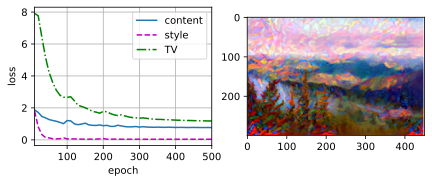

In [22]:
'''
- 获取设备`device`（尝试使用GPU）。
- 设置图像形状`image_shape`。
- 将神经网络移动到设备上。
- 获取内容图像的特征。
- 获取风格图像的特征。
- 训练生成图像，学习率为0.3，训练500个周期，每50个周期衰减学习率。

'''
device, image_shape = d2l.try_gpu(), (300, 450)
net = net.to(device)
content_X, content_Y = get_contents(image_shape, device)
_, styles_Y = get_styles(image_shape, device)
output = train(content_X, content_Y, styles_Y, device, 0.3, 500, 50)